# Filtrando ruido con filtros adaptativos

## Librerias

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
IMAGES_DIR = '../resources/images/denoising'

## Cargar imágen

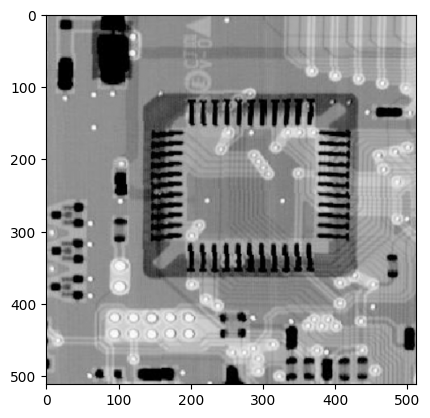

In [32]:
# cargar imagen y convertir a escala de grises
circuit_img = cv.imread(f'{IMAGES_DIR}/xray_circuit.tif')
imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
imgray = cv.resize(imgray, (512,512))
plt.imshow(imgray, cmap='gray')
plt.show()

# **Reto No. 1: Implementa el filtro adaptativo de ruido local**

In [41]:
def sampler(source, pixel_core, padding_core):
    lower_lim = pixel_core[0] - padding_core
    upper_lim = pixel_core[0] + padding_core
    left_lim = pixel_core[1] - padding_core
    right_lim = pixel_core[1] + padding_core

    return source[lower_lim:(upper_lim + 1), left_lim:(right_lim + 1)]

def adpt_local(image, var_noise, patch_size=3):
    height, width = image.shape
    var_img = np.var(image)
    output = np.ones(image.shape)

    for row in range(height):
        for column in range(width):
            pixel = image[row, column]

            padding = patch_size // 2
            pad_image = np.pad(image, padding, mode = "reflect")
            core_wndw = [row + padding, column + padding]
            window = sampler(pad_image, core_wndw, padding)
            output[row, column] = pixel - (var_noise / np.var(window)) * (pixel - np.mean(window))

    return output

In [29]:
sampler(imgray, [1, 1], 1).shape

(3, 3)

In [28]:
imgray[0:3, 0:3]

array([[175, 175, 170],
       [178, 178, 169],
       [181, 181, 169]], dtype=uint8)

# **Reto No. 2: Implementa el filtro adaptativo de la mediana**

In [38]:
def z_params(patch):
    x_sz, y_sz = patch.shape
    z_mid = patch[x_sz // 2, y_sz // 2]
    return [np.min(patch), np.max(patch), np.median(patch), z_mid]

def adpt_median_step(img, pixel_pos, size_min=3, size_max=11):
    new_pixel = 0
    for sz in range(size_min, size_max + 1, 2):
        padding = sz // 2
        pad_image = np.pad(img, padding, mode = "reflect")

        x, y = pixel_pos
        core_wndw = [x + padding, y + padding]
        window = sampler(pad_image, core_wndw, padding)
        
        z_min, z_max, z_median, z_mid = z_params(window)
        
        is_levelA = True
        if is_levelA:
            # Level A conditions.
            if z_min < z_median < z_max:
                is_levelA = False
            elif sz < size_max:
                continue
            else:
                print(f'Reach size max in {pixel_pos}')
                new_pixel = z_median
                break
        if not is_levelA:
            # Level B conditions.
            if z_min < z_mid < z_max:
                new_pixel = z_mid
            else:
                new_pixel = z_median
            break
    return new_pixel

In [39]:
def adpt_median(image, size_max=5):
    height, width = image.shape    
    output = np.ones(image.shape)

    for row in range(height):
        for column in range(width):
            output[row, column] = adpt_median_step(image, [row, column], size_max=size_max)
    
    return output.astype("uint8")

# **Agregando y Filtrando Ruido**

1. Ruido blanco (De lectura = Gauss)
2. Ruido Sal y Pimienta (Impulsivo)
3. Ruido de disparo (Shot noise = Poisson)


# White noise

El ruido blanco es un ruido aditivo Gaussiano que es i.i.d. de media cero. Es el modelo más común para generar imágenes de ruido. Es difícil lidiar con este tipo de ruido incluso en el dominio de la frecuencia, ya que tiene la misma intensidad en todas las frecuencias. ​

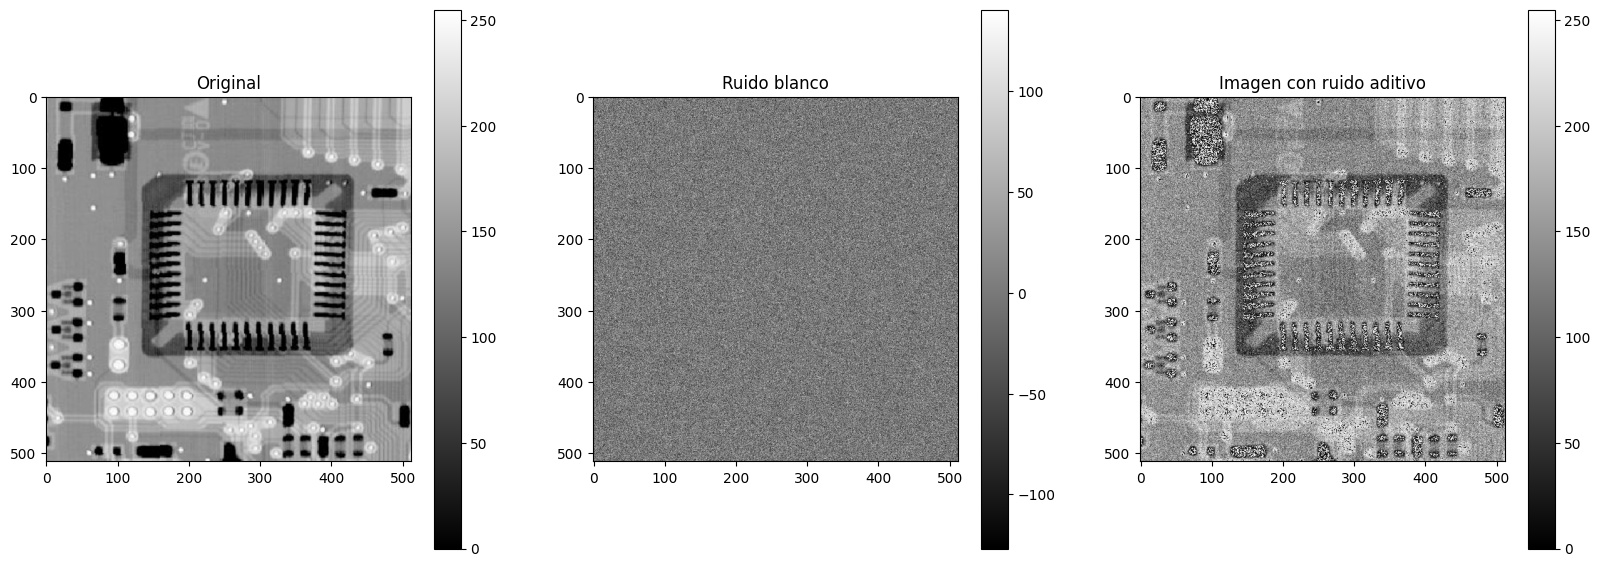

In [7]:
NOISE_STD = 30  # Desviación estándar del ruido a agregar

noise = np.random.normal(scale=NOISE_STD, size=imgray.shape)
noisy_image_White = (imgray + noise).astype('uint8')

plt.figure(figsize=(20,7))
plt.subplot(131), plt.imshow(imgray, cmap='gray'), plt.title('Original'); plt.colorbar();
plt.subplot(132), plt.imshow(noise, cmap='gray'), plt.title('Ruido blanco'); plt.colorbar();
plt.subplot(133), plt.imshow(noisy_image_White, cmap='gray'), plt.title('Imagen con ruido aditivo'); plt.colorbar();

# Salt & pepper noise

El ruido de sal y pimienta se presenta como píxeles blancos y negros que aparecen escasamente. Puede ocurrir debido al uso de instrumentos defectuosos.

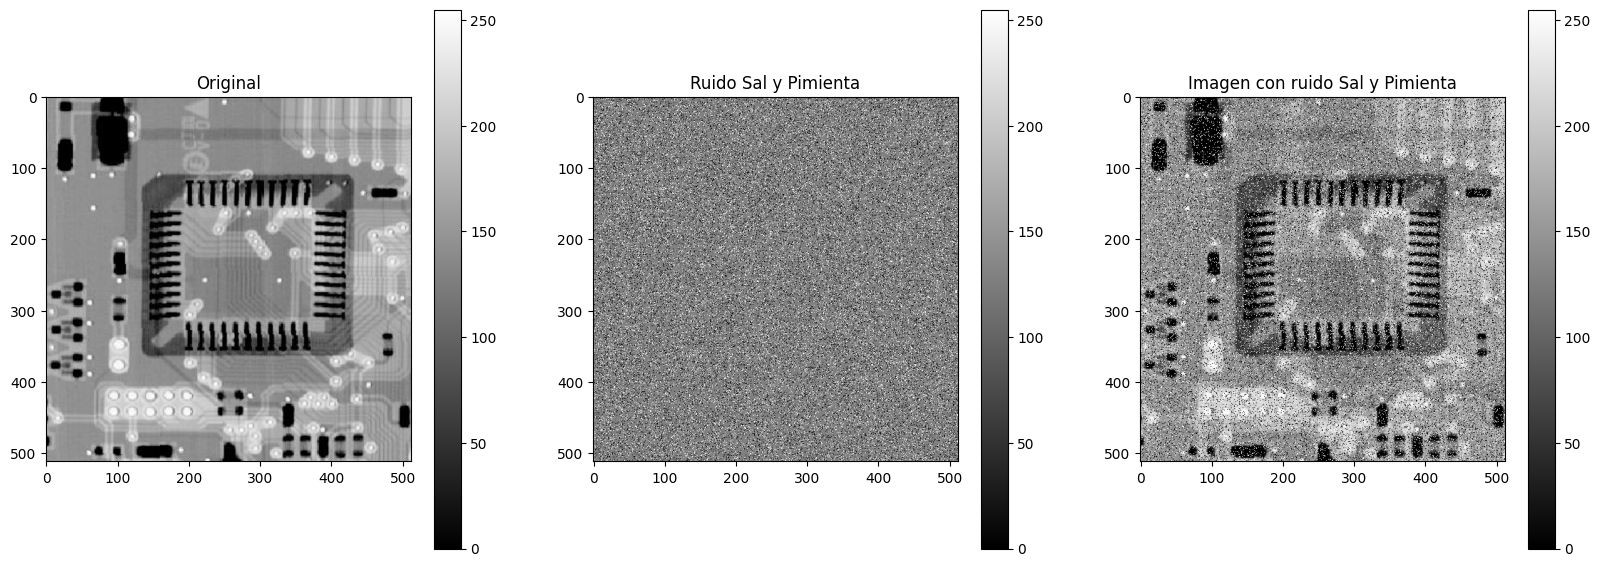

In [8]:
AMOUNT = 0.2   # proporcion de pixeles a ser afectados
SALT_VS_PEPPER = 0.5  # probabilidad de ser negro o saturado

noisy_image_SP = imgray.copy()
number_faulty_pixels = np.ceil(AMOUNT * imgray.size).astype(int)
indices = np.random.randint(0, high=512, size=(2, number_faulty_pixels))
values = np.random.binomial(1, SALT_VS_PEPPER, size=number_faulty_pixels)
noisy_image_SP[tuple(np.split(indices, 2))] = values*255

noise = np.ones(imgray.shape)*128
noise[tuple(np.split(indices, 2))] = values*255

plt.figure(figsize=(20,7))
plt.subplot(131), plt.imshow(imgray, cmap='gray'), plt.title('Original'); plt.colorbar();
plt.subplot(132), plt.imshow(noise, cmap='gray'), plt.title('Ruido Sal y Pimienta'); plt.colorbar();
plt.subplot(133), plt.imshow(noisy_image_SP, cmap='gray'), plt.title('Imagen con ruido Sal y Pimienta'); plt.colorbar();

# Shot Noise

El ruido de disparo es cualquier tipo discreto de ruido que puede modelarse como un proceso de Poisson. Ocurre en el conteo de fotones en dispositivos ópticos, debido a la naturaleza como partícula de la luz. Por tanto, este tipo de ruido se nota especialmente en condiciones de poca luz, o cuando el tiempo de exposición es corto.

No debe confundirse con el ruido oscuro *(dark noise)*, que es un ruido de Poisson aditivo.

Note que los píxeles brillantes serán más ruidosos que los oscuros, porque $E[X] = Var[X] = \lambda$.

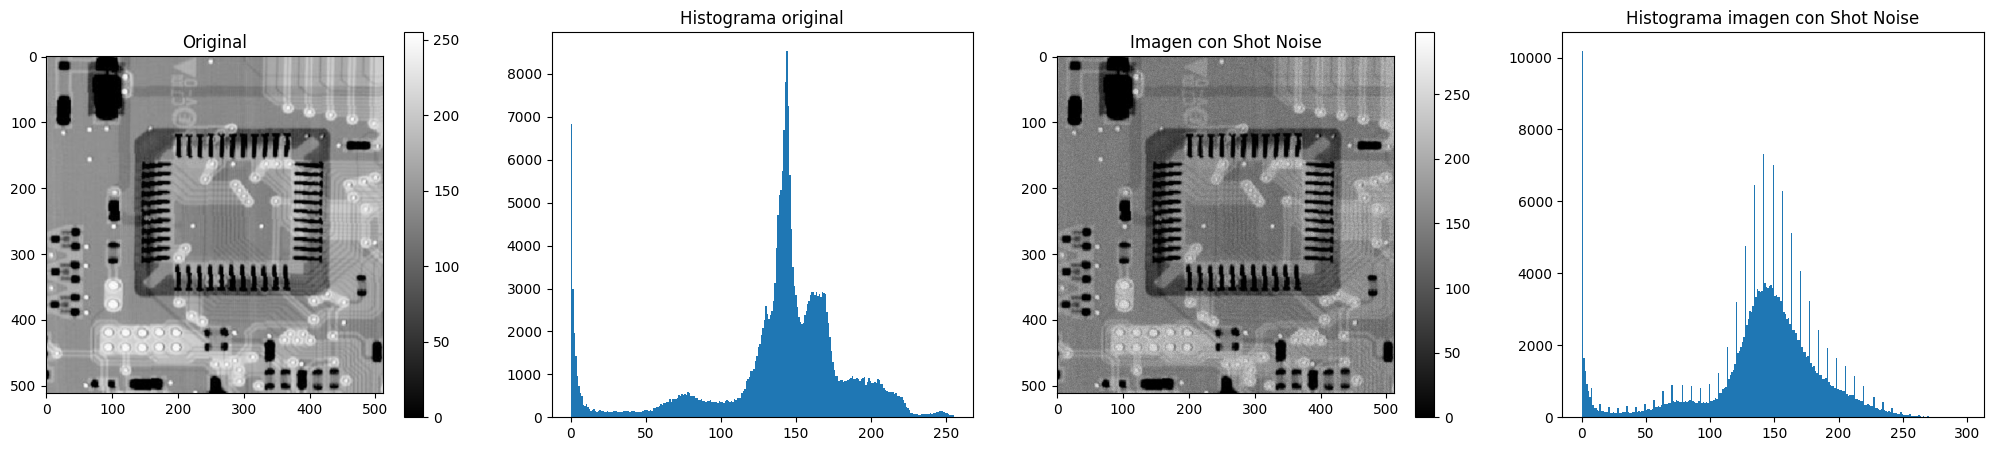

In [9]:
noisy_image_Shot = np.random.poisson(lam=imgray)

plt.figure(figsize=(25,5))
plt.subplot(141), plt.imshow(imgray, cmap='gray'), plt.title('Original'); plt.colorbar();
plt.subplot(142), plt.hist(imgray.ravel(), bins=256), plt.title('Histograma original');
plt.subplot(143), plt.imshow(noisy_image_Shot, cmap='gray'), plt.title('Imagen con Shot Noise'); plt.colorbar();
plt.subplot(144), plt.hist(noisy_image_Shot.ravel(), bins=256), plt.title('Histograma imagen con Shot Noise');
noisy_image_Shot = noisy_image_Shot.astype('uint8')

# Reto No. 3: Aplicar los filtros a las imagenes ruidosas y analizar los resultados

In [10]:
# Implentación de la función de cálculo de errores RMSE y MAE
def calcular_errores(img_est, img_ref):
    ''' Calcular el error cuadrático medio (RMSE) y el error absoluto medio (MAE)
    entre la imagen de referencia y la filtrada '''
    RMSE = np.sqrt(np.mean(np.power(img_ref - img_est, 2)))
    MAE = np.mean(np.abs(img_ref - img_est))

    return RMSE, MAE

Definimos las funciones para agregar los diferentes tipos de ruido a una imagen.

In [12]:
def noise_gaussian(image, std=1):
    noise = np.random.normal(scale=std, size=image.shape)
    gauss_img = (image + noise).astype('uint8')
    return gauss_img

def noise_salt_pepper(image, prob_affect=0.2):
    # Probability to be black or white.
    SALT_VS_PEPPER = 0.5

    base_img = image.copy()
    number_faulty_pixels = np.ceil(prob_affect * gauss_img.size).astype(int)
    indices = np.random.randint(0, high=512, size=(2, number_faulty_pixels))
    values = np.random.binomial(1, SALT_VS_PEPPER, size=number_faulty_pixels)
    base_img[tuple(np.split(indices, 2))] = values*255
    return base_img

def noise_shot(image):
    return np.random.poisson(lam=image)

## 3.1 Agrega ruido Gaussiano y Salt & Pepper y compara los resultados de los filtros calculando el RMSE y MAE. ¿Cuál es mejor removiendo el ruido? Comenta tus resultados.


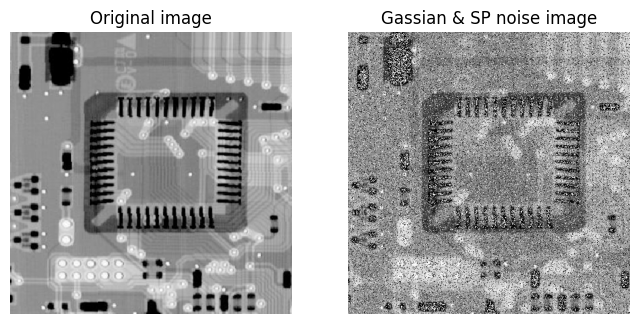

In [36]:
gauss_img = noise_gaussian(imgray, 5)
sp_img = noise_salt_pepper(gauss_img)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.imshow(imgray, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(sp_img, cmap='gray')
plt.axis('off')
plt.title('Gassian & SP noise image')
plt.show()

In [47]:
sp_img_local = adpt_local(sp_img, 5)
sp_img_median = adpt_median(sp_img)

sp_img_local_err = calcular_errores(sp_img_local, imgray)
sp_img_median_err = calcular_errores(sp_img_median, imgray)

Reach size max in [0, 88]
Reach size max in [30, 84]
Reach size max in [31, 84]
Reach size max in [48, 73]
Reach size max in [48, 74]
Reach size max in [133, 350]


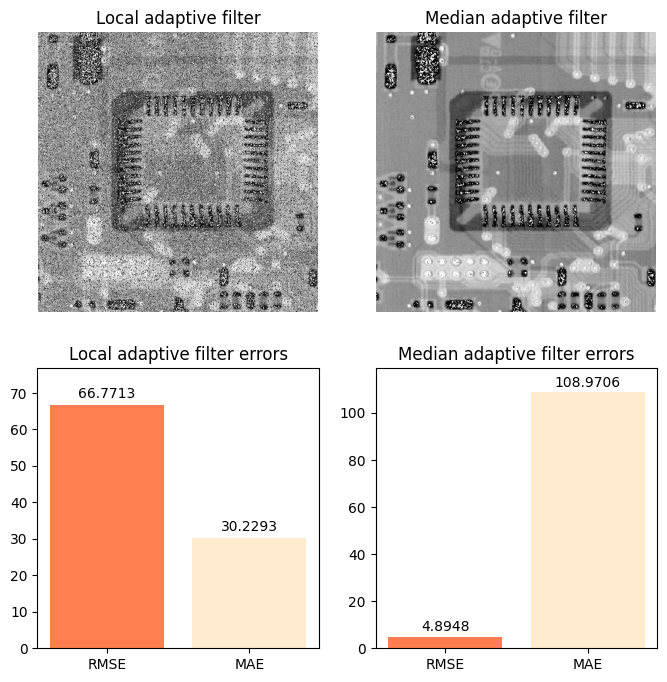

In [65]:
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(sp_img_local, cmap='gray')
plt.axis('off')
plt.title('Local adaptive filter')
plt.subplot(2, 2, 2)
plt.imshow(sp_img_median, cmap='gray')
plt.axis('off')
plt.title('Median adaptive filter')

plt.subplot(2, 2, 3)
plt.bar(['RMSE', 'MAE'], sp_img_local_err, color=['coral', 'blanchedalmond'])
for i in range(2):
    n = f'{sp_img_local_err[i]:.4f}'
    plt.text(i, sp_img_local_err[i] + 1, n, ha='center', va='bottom')
plt.ylim(0, max(sp_img_local_err) + 10)
plt.title('Local adaptive filter errors')
plt.subplot(2, 2, 4)
plt.bar(['RMSE', 'MAE'], sp_img_median_err, color=['coral', 'blanchedalmond'])
for i in range(2):
    n = f'{sp_img_median_err[i]:.4f}'
    plt.text(i, sp_img_median_err[i] + 1, n, ha='center', va='bottom')
plt.ylim(0, max(sp_img_median_err) + 10)
plt.title('Median adaptive filter errors')
plt.show()

## Tus comentarios sobre los resultados aquí:

Con el filtro adaptativo local obtenemos una imagen que contiene ruido de *Salt & Pepper* aún; mientras que, con el otro filtro el ruido ha desaparecido ha excepción de zonas puntuales de la imagen. Las métricas muestran que el filtro adaptativo para la mediana tiene mejores resultados.

## 3.2 Agrega ruido Gaussiano y Poisson, y compara los resultados de los filtros calculando el RMSE y MAE. ¿Cuál es mejor removiendo el ruido? Comenta tus resultados.

In [66]:
gauss_img2 = noise_gaussian(imgray, 5)
poiss_img = noise_shot(gauss_img2)

poiss_img_local = adpt_local(poiss_img, 5)
poiss_img_median = adpt_median(poiss_img)

poiss_img_local_err = calcular_errores(poiss_img_local, imgray)
poiss_img_median_err = calcular_errores(poiss_img_median, imgray)

Reach size max in [71, 102]


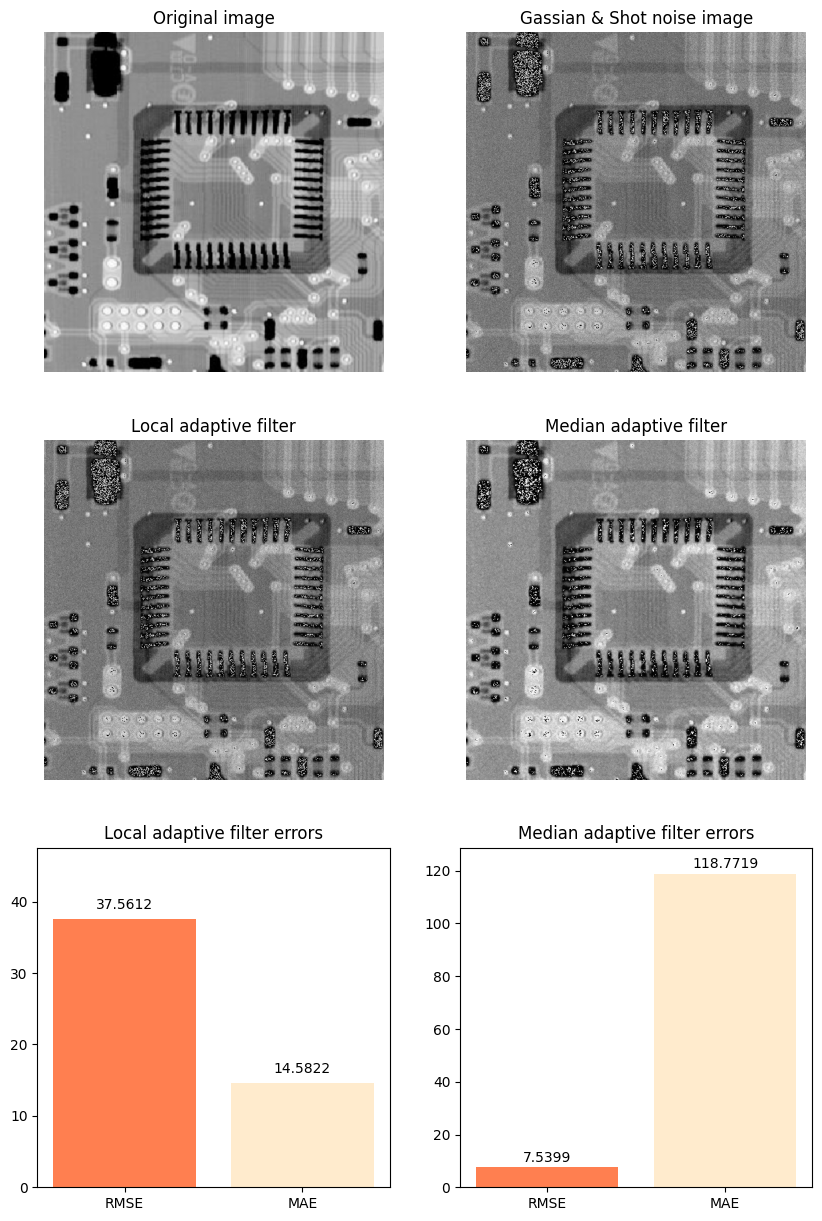

In [72]:
plt.figure(figsize=(10,15))
plt.subplot(3, 2, 1)
plt.imshow(imgray, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.subplot(3, 2, 2)
plt.imshow(poiss_img, cmap='gray')
plt.axis('off')
plt.title('Gassian & Shot noise image')

plt.subplot(3, 2, 3)
plt.imshow(poiss_img_local, cmap='gray')
plt.axis('off')
plt.title('Local adaptive filter')
plt.subplot(3, 2, 4)
plt.imshow(poiss_img_median, cmap='gray')
plt.axis('off')
plt.title('Median adaptive filter')

plt.subplot(3, 2, 5)
plt.bar(['RMSE', 'MAE'], poiss_img_local_err, color=['coral', 'blanchedalmond'])
for i in range(2):
    n = f'{poiss_img_local_err[i]:.4f}'
    plt.text(i, poiss_img_local_err[i] + 1, n, ha='center', va='bottom')
plt.ylim(0, max(poiss_img_local_err) + 10)
plt.title('Local adaptive filter errors')
plt.subplot(3, 2, 6)
plt.bar(['RMSE', 'MAE'], poiss_img_median_err, color=['coral', 'blanchedalmond'])
for i in range(2):
    n = f'{poiss_img_median_err[i]:.4f}'
    plt.text(i, poiss_img_median_err[i] + 1, n, ha='center', va='bottom')
plt.ylim(0, max(poiss_img_median_err) + 10)
plt.title('Median adaptive filter errors')
plt.show()

## Tus comentarios sobre los resultados aquí:

Con la imagen que tiene ruido gaussiano y de disparo, se puede observar detalles del ruido en areas oscuras (casi negras). La imagen recuperada con el filtro de ruido local está más oscura; mientras que, la imagen recuperada con el filtro de la mediana es más clarita. Las métricas siguen el mismo comportamiento general que en el anterior ruido.

## 3.3 Agrega ruido Gaussiano, Poisson y Salt & Pepper y compara los resultados de los filtros calculando el RMSE y MAE. ¿Cuál es mejor removiendo el ruido? Comenta tus resultados.

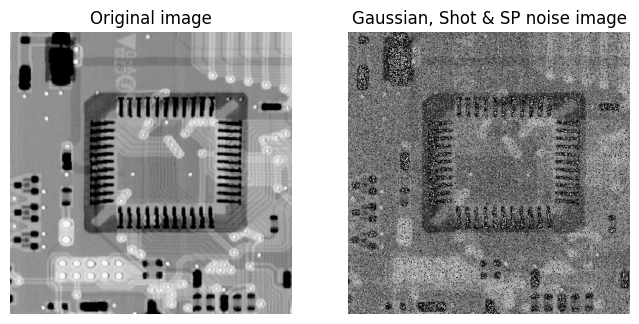

In [74]:
gauss_img3 = noise_gaussian(imgray, 5)
poiss_img2 = noise_shot(gauss_img3)
sp_img2 = noise_salt_pepper(poiss_img2)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.imshow(imgray, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(sp_img2, cmap='gray')
plt.axis('off')
plt.title('Gaussian, Shot & SP noise image')
plt.show()

In [75]:
sp_img2_local = adpt_local(sp_img2, 5)
sp_img2_median = adpt_median(sp_img2)

sp_img2_local_err = calcular_errores(sp_img2_local, imgray)
sp_img2_median_err = calcular_errores(sp_img2_median, imgray)

Reach size max in [8, 105]
Reach size max in [43, 103]
Reach size max in [81, 96]
Reach size max in [87, 26]
Reach size max in [239, 101]
Reach size max in [251, 148]
Reach size max in [499, 71]
Reach size max in [503, 146]
Reach size max in [503, 147]
Reach size max in [503, 148]
Reach size max in [510, 263]
Reach size max in [511, 262]
Reach size max in [511, 263]


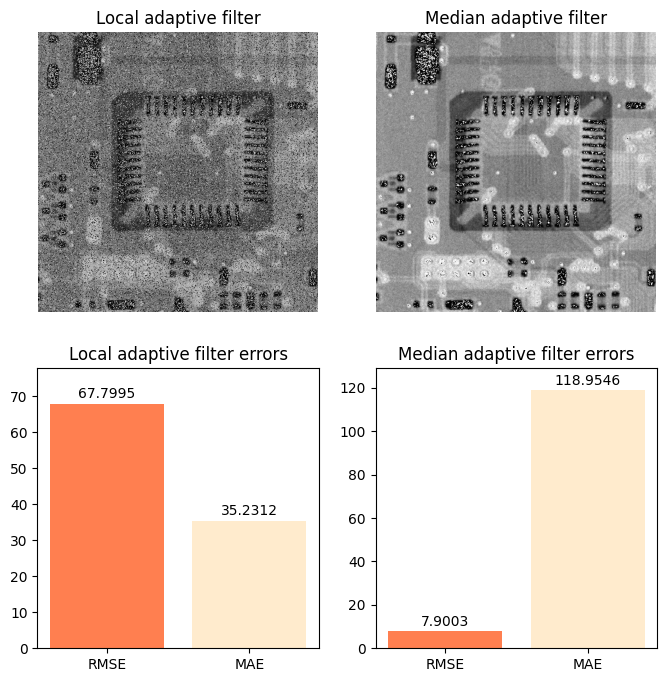

In [76]:
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(sp_img2_local, cmap='gray')
plt.axis('off')
plt.title('Local adaptive filter')
plt.subplot(2, 2, 2)
plt.imshow(sp_img2_median, cmap='gray')
plt.axis('off')
plt.title('Median adaptive filter')

plt.subplot(2, 2, 3)
plt.bar(['RMSE', 'MAE'], sp_img2_local_err, color=['coral', 'blanchedalmond'])
for i in range(2):
    n = f'{sp_img2_local_err[i]:.4f}'
    plt.text(i, sp_img2_local_err[i] + 1, n, ha='center', va='bottom')
plt.ylim(0, max(sp_img2_local_err) + 10)
plt.title('Local adaptive filter errors')
plt.subplot(2, 2, 4)
plt.bar(['RMSE', 'MAE'], sp_img2_median_err, color=['coral', 'blanchedalmond'])
for i in range(2):
    n = f'{sp_img2_median_err[i]:.4f}'
    plt.text(i, sp_img2_median_err[i] + 1, n, ha='center', va='bottom')
plt.ylim(0, max(sp_img2_median_err) + 10)
plt.title('Median adaptive filter errors')
plt.show()

## Tus comentarios sobre los resultados aquí

Cuando se combinan los 3 ruidos en una misma imagen, cada uno de los filtros matiene las forma de las métricas en general.